In [23]:
import pandas as pd
import numpy as np
import os
import glob
import h5py
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi']= 800
plt.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#FF5F05", "#13294B", "#009FD4", "#FCB316", "#006230", "#007E8E", "#5C0E41", "#7D3E13"])

In [24]:
raw_data_dir = os.path.join("data", "raw")
all_paths = glob.glob(os.path.join(raw_data_dir, "**", "*"), recursive=True)
all_files = [f for f in all_paths if (os.path.isfile(f)) & (f.endswith(".h5"))]

In [25]:
# f = h5py.File(all_files[3], 'r')
# grp_name = "Soil_Moisture_Retrieval_Data_AM"  # or "_PM" if you prefer evenings
# G = f[grp_name]

# sm = G["soil_moisture"][()]           # m3/m3
# lat = G["latitude"][()]
# lon = G["longitude"][()]

# fill = -9999
# sm = np.where(sm == fill, np.nan, sm)
# print(all_files[1])
# print(lat)
# print(lon)
# print(sm)

In [26]:
raw_data_dir = os.path.join("data", "raw")
all_paths = glob.glob(os.path.join(raw_data_dir, "**", "*.h5"), recursive=True)
all_files = sorted([f for f in all_paths if os.path.isfile(f)])

FILL = -9999.0

def summarize_file(fpath, group, varname, hour, label):
    """Return a one-row dict with datetime, sm_mean, quality, and label."""
    fname = os.path.basename(fpath)
    # SMAP_L3_SM_P_E_YYYYMMDD_...
    ymd = fname.split("_")[5]  # your revised index
    date = datetime.strptime(ymd, "%Y%m%d")
    dt = datetime.combine(date, datetime.min.time()).replace(hour=hour)

    try:
        with h5py.File(fpath, "r") as f:
            G = f[group]
            sm = G[varname][()].astype(float)
    except Exception:
        return None  # group/var missing → skip

    sm = np.where((sm == FILL) | ~np.isfinite(sm), np.nan, sm)
    valid = np.isfinite(sm)
    sm_mean = float(np.nanmean(sm)) if valid.any() else np.nan
    quality = int(valid.sum())
    return {"date": dt, "sm": sm_mean, "quality": quality, "pass": label}

# AM (06:00) — group/var names for AM
am_group = "Soil_Moisture_Retrieval_Data_AM"
am_var   = "soil_moisture"  # pointer to DCA in SPL3SMP_E

# PM (18:00) — your specified names
pm_group = "Soil_Moisture_Retrieval_Data_PM"
pm_var   = "soil_moisture_dca_pm"

rows_am = []
rows_pm = []
for fpath in all_files:
    r_am = summarize_file(fpath, am_group, am_var, 6, "AM")
    if r_am: rows_am.append(r_am)
    r_pm = summarize_file(fpath, pm_group, pm_var, 18, "PM")
    if r_pm: rows_pm.append(r_pm)

df_am = pd.DataFrame(rows_am)
df_pm = pd.DataFrame(rows_pm)

# Concatenate and sort
df = pd.concat([df_am, df_pm], ignore_index=True).sort_values("date").reset_index(drop=True)


In [27]:
df.to_csv('./data/processed/SMAP/smap_summary.csv', index=False)

In [28]:
df.set_index("date", inplace=True)

(19083.0, 19112.0)

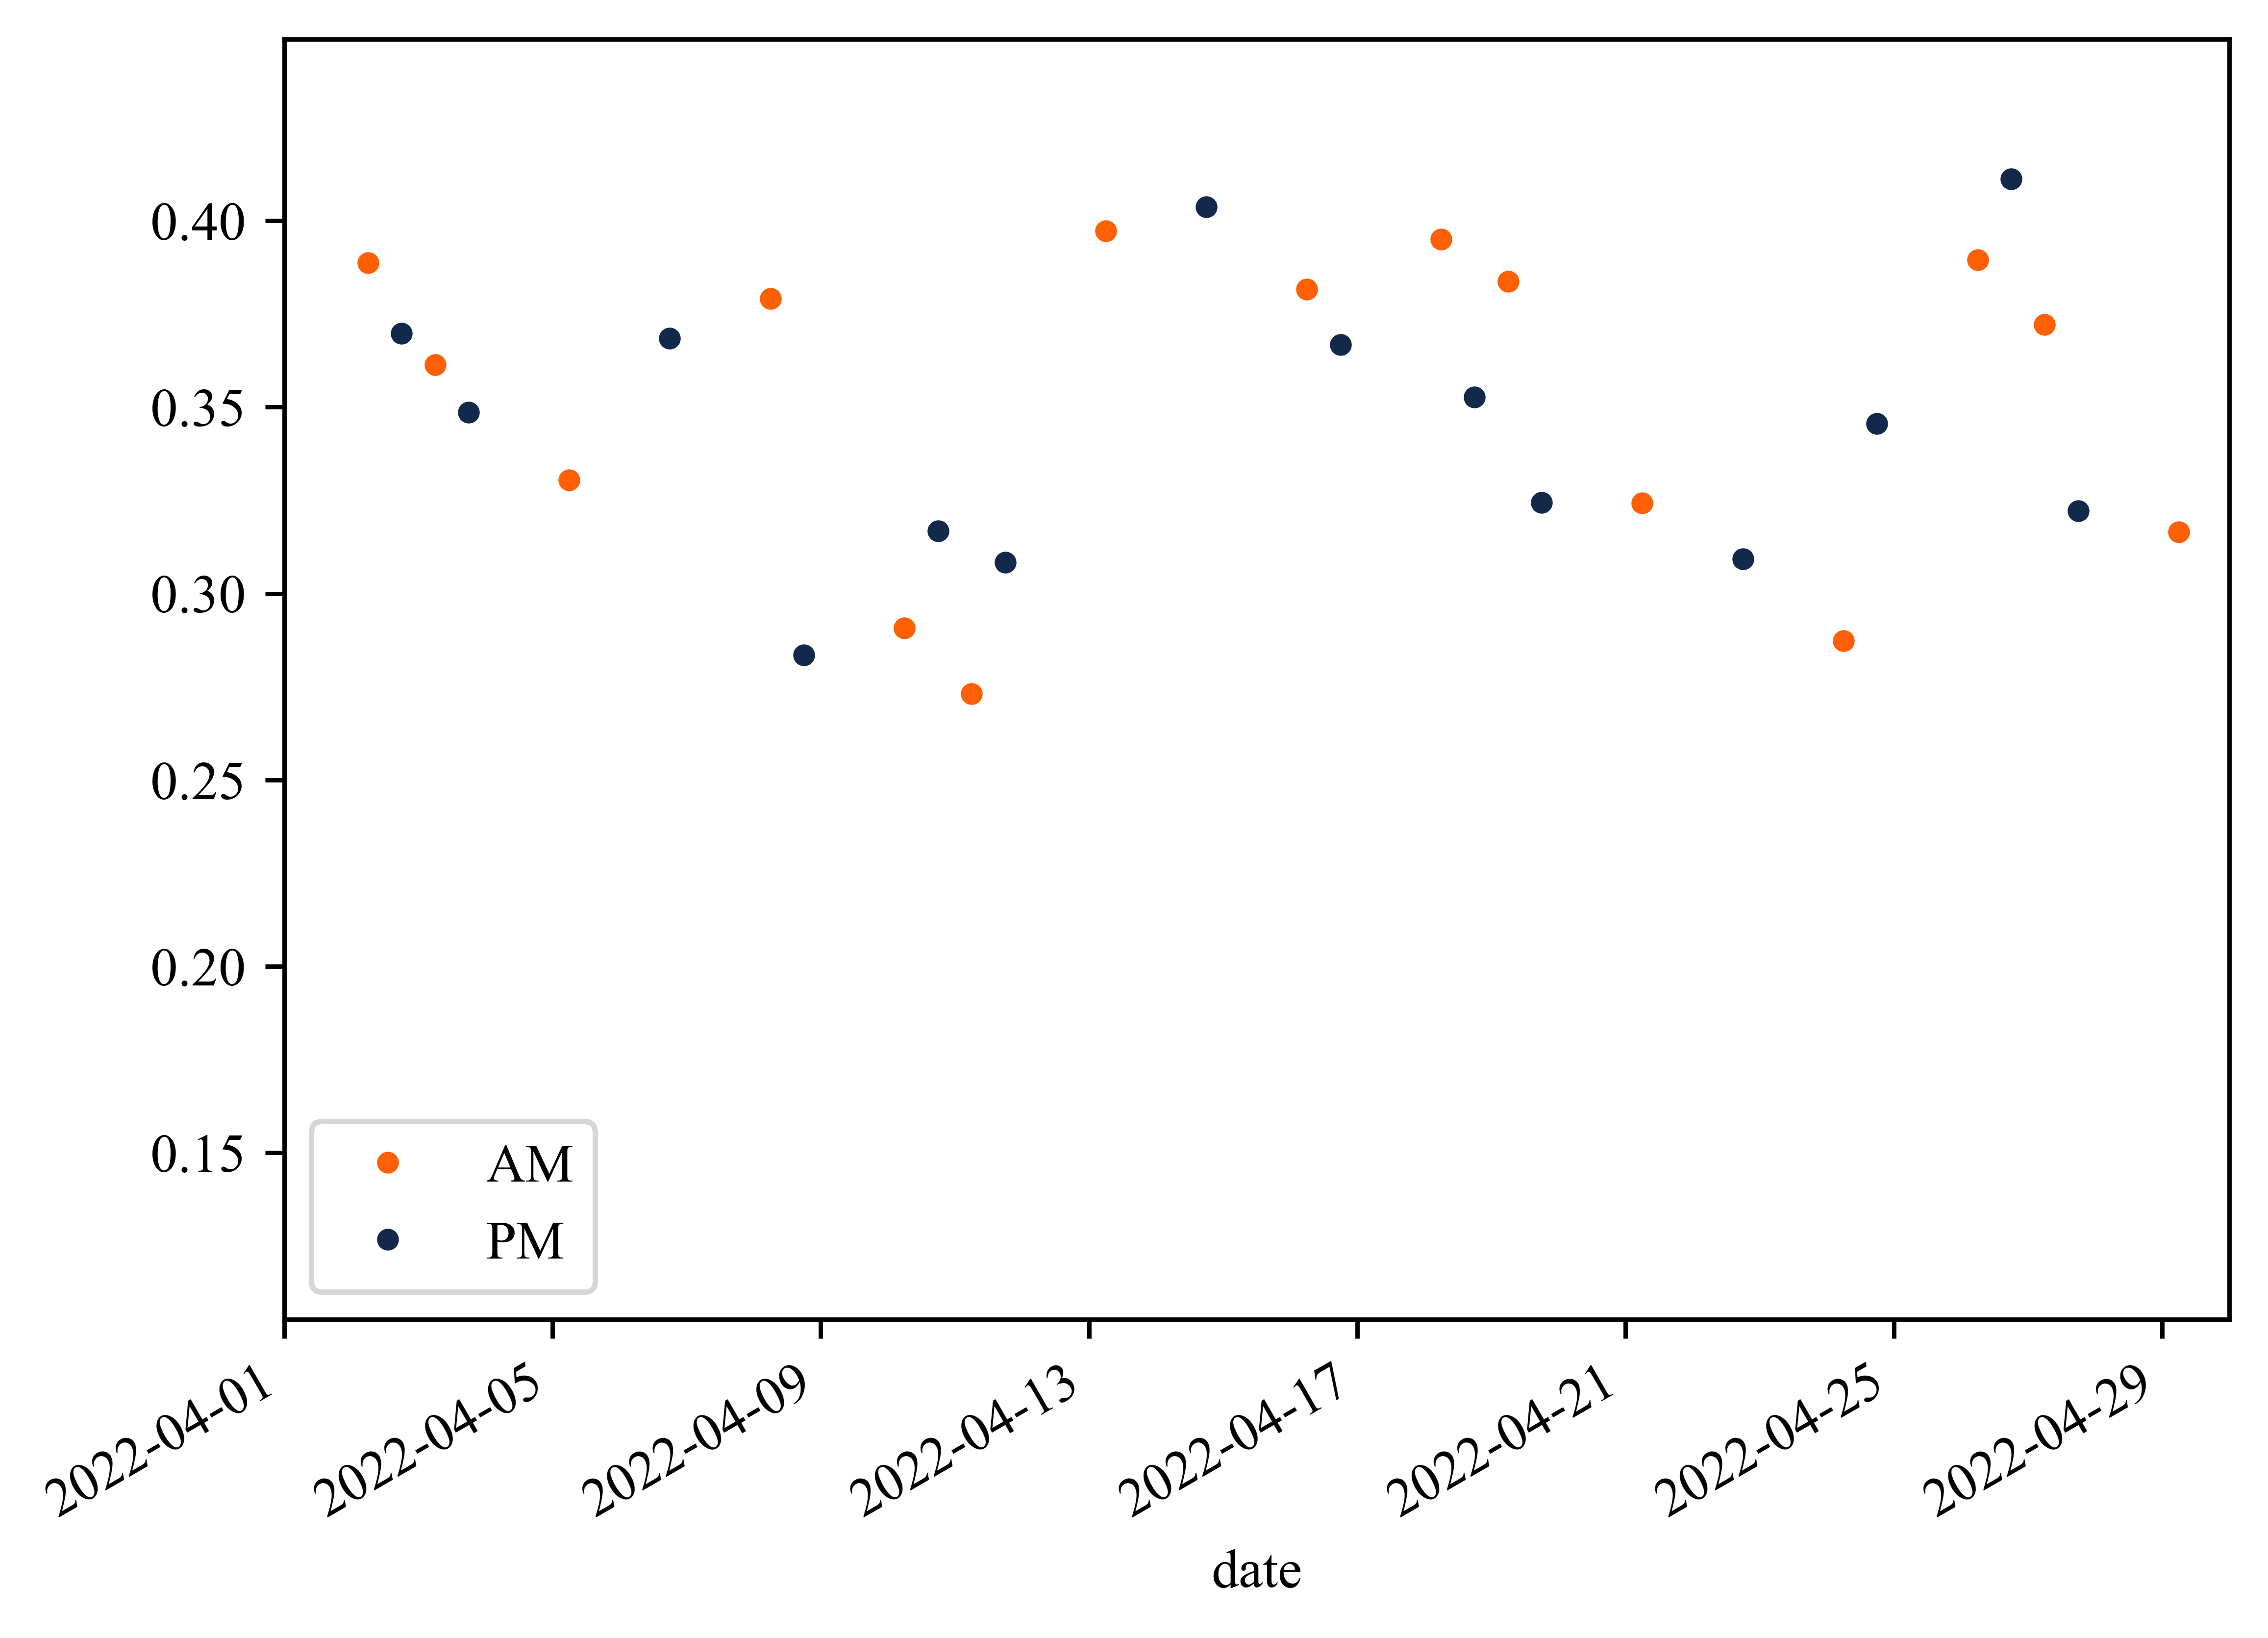

In [29]:
ax = df.loc[(df['pass'] == 'AM') & (df['quality'] > 0)].plot(y='sm', label='AM', marker='.', linestyle='None', color='#FF5F05')
df.loc[(df['pass'] == 'PM') & (df['quality'] > 0)].plot(y='sm', label='PM', marker='.', linestyle='None', color='#13294B', ax=ax)

ax.set_xlim([pd.Timestamp("2022-04-01"), pd.Timestamp("2022-04-30")])